# Задание 3. Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas

In [2]:
FILE_ID = '1kMfYaVq2cyXhGtCxPJPkvLWh1I-YhU2H'

In [3]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kMfYaVq2cyXhGtCxPJPkvLWh1I-YhU2H' -O 'lin_reg.txt'

--2023-01-09 10:33:01--  https://docs.google.com/uc?export=download&id=1kMfYaVq2cyXhGtCxPJPkvLWh1I-YhU2H
Resolving docs.google.com (docs.google.com)... 172.253.62.139, 172.253.62.138, 172.253.62.102, ...
Connecting to docs.google.com (docs.google.com)|172.253.62.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jd6pu858v6oq1tnb8uu50ah8otdliaph/1673260350000/16775244520241009086/*/1kMfYaVq2cyXhGtCxPJPkvLWh1I-YhU2H?e=download&uuid=ccc1f0ab-ce9b-486d-a548-d57abbf0762b [following]
--2023-01-09 10:33:01--  https://doc-08-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jd6pu858v6oq1tnb8uu50ah8otdliaph/1673260350000/16775244520241009086/*/1kMfYaVq2cyXhGtCxPJPkvLWh1I-YhU2H?e=download&uuid=ccc1f0ab-ce9b-486d-a548-d57abbf0762b
Resolving doc-08-7s-docs.googleusercontent.com (doc-08-7s-docs.googleusercontent.com)... 172.253.122.132, 2607:f8b0

In [4]:
D = np.loadtxt('/content/lin_reg.txt', delimiter=',')
X_data = D[:, :-1]
Y_data = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [5]:
X_data

array([[  9.31 , -17.043,  20.807,  11.109],
       [ -6.446, -12.46 , -12.941, -14.715],
       [ 14.324,  -9.624,  29.533,   1.439],
       ...,
       [  3.56 ,   2.063,   7.302,  -7.817],
       [ 11.841, -14.315,  23.148,  11.777],
       [ -3.345, -15.219,  -4.751,  -1.141]])

In [8]:
class LinearRegression():

    def __init__(self, alpha=0, n_iter=1000, lr=1e-3):
        self.n_iter = n_iter
        self.lr = lr
        self.alpha = alpha
        self.weights = None
    
    def fit(self, X_train, y_train):
        X_conc = np.concatenate([X_train, np.ones((X_train.shape[0], 1))], axis=1)
        self.weights = np.random.randn(X_conc.shape[1]) * 0.01

        for i in range(self.n_iter):
            y_pred = X_conc.dot(self.weights)
            
            gradient = 2 * X_conc.T.dot(y_pred - y_train) / X_conc.shape[0] + 2 * self.alpha * self.weights

            self.weights -= self.lr * gradient
        

    def predict(self, X):
        X_conc = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        return X_conc.dot(self.weights)

    def error(self, X, y):
        preds = self.predict(X)
        return np.mean((preds - y)**2) / X.shape[0]

    def plot_alpha_error(self, X, y):
        alphas = np.linspace(0, 200, num=201)

        errors = []

        for alpha in alphas:
            self.alpha = alpha
            
            self.fit(X, y)
            
            errors.append(self.error(X, y))

        plt.plot(alphas, errors, label='Reg parameter alpha VS MSE')
        plt.xlabel('Regularization parameter alpha')
        plt.ylabel('Mean squared error')
        plt.legend()
        plt.show()

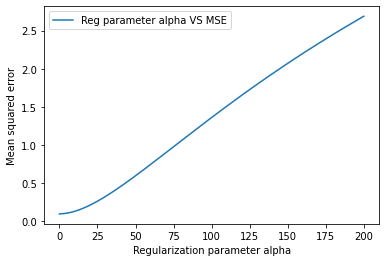

In [9]:
model = LinearRegression()
model.plot_alpha_error(X_data, Y_data)

In [10]:
def k_fold_cross_val(model, X, y, k=5):
    num_folds = k

    data = np.concatenate([X, y.reshape(-1, 1)], axis=1)

    permuted_data = np.random.permutation(data)

    X = permuted_data[:, :-1]
    y = permuted_data[:, -1]

    fold_size = X.shape[0] // num_folds
    X_folds = np.split(X, num_folds)
    y_folds = np.split(y, num_folds)

    errors = []

    for i in range(num_folds):
        X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
        y_train = np.concatenate(y_folds[:i] + y_folds[i+1:])
        X_test = X_folds[i]
        y_test = y_folds[i]

        model.fit(X_train, y_train)
                
        single_error = model.error(X_test, y_test)

        errors.append(single_error)

    mean_error = np.mean(errors)
    std_error = np.std(errors)
    return mean_error, std_error

In [11]:
def find_optimal_alpha(X, y):
    alphas = np.linspace(0, 200, num=201)

    mean_errors = []
    std_errors = []

    for alpha in alphas:
        model = LinearRegression(alpha=alpha)
        
        mean_error, std_error = k_fold_cross_val(model, X, y)
        mean_errors.append(mean_error)
        std_errors.append(std_error)

    opt_index = np.argmin(mean_errors)
    opt_alpha = alphas[opt_index]
    opt_mean_error = mean_errors[opt_index]
    opt_std_error = std_errors[opt_index]
    
    return opt_alpha, opt_mean_error, opt_std_error

In [12]:
optimal_alpha, mean_error, std_error = find_optimal_alpha(X_data, Y_data)
print("Optimal alpha: {optimal_alpha:.4f}".format(optimal_alpha=optimal_alpha))
print("Mean squared error: {mean_error:.4f} STD error: {std_error:.4f}".format(mean_error=mean_error, std_error=std_error))

Optimal alpha: 0.0000
Mean squared error: 0.4841 STD error: 0.0363


In [25]:
class LinearRegressionWithCurves():

    def __init__(self, alpha=0, n_iter=1000, lr=1e-3):
        self.n_iter = n_iter
        self.lr = lr
        self.alpha = alpha
        self.weights = None
    
    def fit(self, X_train, y_train, X_test, y_test):
        X_conc = np.concatenate([X_train, np.ones((X_train.shape[0], 1))], axis=1)
        self.weights = np.random.randn(X_conc.shape[1]) * 0.01

        train_errors = []
        val_errors = []

        for i in range(self.n_iter):
            y_pred = X_conc.dot(self.weights)
            
            gradient = 2 * X_conc.T.dot(y_pred - y_train) / X_conc.shape[0] + 2 * self.alpha * self.weights

            self.weights -= self.lr * gradient
        
            train_errors.append(self.error(X_train, y_train))
            val_errors.append(self.error(X_test, y_test))
        
        return train_errors, val_errors

    def predict(self, X):
        X_conc = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        return X_conc.dot(self.weights)

    def error(self, X, y):
        preds = self.predict(X)
        return np.mean((preds - y)**2) / X.shape[0]

In [32]:
def k_fold_cross_val_with_plotting(model, X, y, k=5):
    num_folds = k

    data = np.concatenate([X, y.reshape(-1, 1)], axis=1)

    permuted_data = np.random.permutation(data)

    X = permuted_data[:, :-1]
    y = permuted_data[:, -1]

    fold_size = X.shape[0] // num_folds
    X_folds = np.split(X, num_folds)
    y_folds = np.split(y, num_folds)

    all_train_errors = []
    all_val_errors = []

    for i in range(num_folds):
        X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
        y_train = np.concatenate(y_folds[:i] + y_folds[i+1:])
        X_test = X_folds[i]
        y_test = y_folds[i]

        train_errors, val_errors = model.fit(X_train, y_train, X_test, y_test)

        all_train_errors.append(train_errors)
        all_val_errors.append(val_errors)
    
    all_train_errors = np.array(all_train_errors).mean(axis=0)
    all_val_errors = np.array(all_val_errors).mean(axis=0)

    plt.plot(np.arange(model.n_iter), all_train_errors, "r-+", linewidth=2, label="train")
    plt.plot(np.arange(model.n_iter), all_val_errors, "b-", linewidth=3, label="val")
    plt.xlabel('Steps')
    plt.ylabel('Mean squared error')
    plt.legend()
    plt.show()

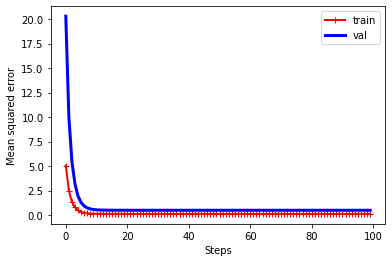

In [33]:
model = LinearRegressionWithCurves(alpha = 1, n_iter=100)
k_fold_cross_val_with_plotting(model, X_data, Y_data)